In [1]:
# read the data in

import pandas as pd
import numpy as np
import sys

def exit_with_error(message):
    print(f"Error: {message}")
    sys.exit(1)

metadata_fname = "data\\metadata_wide.tsv"
quants_fname = "data\\proteins_wide_normalized.tsv"
targets_fname = "data\\targets.tsv"

metadata = pd.read_csv(metadata_fname, sep='\t', na_values=['N/A'])
data = pd.read_csv(quants_fname, sep='\t')
data = data.fillna(0)
targets = pd.read_csv(targets_fname, sep='\t')
protein_names = data['protein'].values

print("Metadata shape:", metadata.shape)
print("Data shape:", data.shape)

Metadata shape: (120, 18)
Data shape: (5360, 121)


Data shape: (100, 5360)
Doses: [75.   0.  75.  10.  32.5 75.  75.  32.5 10.   0.  75.  10.  32.5 32.5
 75.   0.  75.  10.  10.  32.5 10.  32.5 75.  10.  32.5 32.5  0.  75.
 75.  10.   0.  10.   0.  32.5 75.  32.5 32.5 10.  75.  75.  32.5 75.
 75.  10.  10.  75.   0.  32.5 32.5  0.  10.  10.  75.  75.   0.  32.5
 75.  10.  10.  32.5 32.5 75.  10.   0.  75.  10.  10.  32.5  0.  32.5
 75.  10.  32.5 75.  32.5 75.  10.  32.5  0.  10.  75.  75.  10.  32.5
 32.5  0.  32.5 32.5 10.  75.  10.  75.  75.  10.  32.5  0.  75.  10.
  0.  32.5]


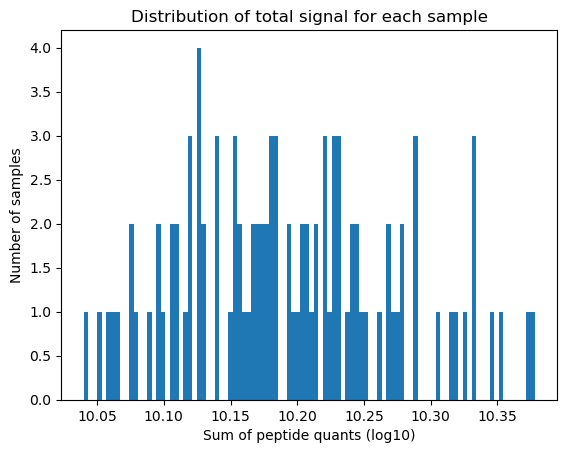

In [2]:
# transform data into what Justin's code is expecting

import matplotlib.pyplot as plt

valid_replicates = metadata[
    (metadata['TargetDose_cGy'].notna()) & 
    (metadata['TargetDose_cGy'] != 'na')
]['replicate'].tolist()

X = []
rad = []
rates = []
ir_type = []

for idx in valid_replicates:
  for sample in data.columns[:]:
    if idx in sample:
      s_rad = metadata[metadata['replicate'] == idx]['TargetDose_cGy'].values[0]
      s_ir_type = metadata[metadata['replicate'] == idx]['IR_Type'].values[0]

      rad.append(s_rad)
      ir_type.append(s_ir_type)
      X.append(data[sample].values)

X = np.array(X)
rad = np.array(rad).astype(float)
ir_type = np.array(ir_type)

print("Data shape:", X.shape)
print("Doses:", rad)

total_signal = np.sum(X, axis=1)
plt.hist(np.log10(total_signal), bins = 100)
plt.title('Distribution of total signal for each sample')
plt.ylabel('Number of samples')
plt.xlabel('Sum of peptide quants (log10)')
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict, Union
import warnings

def crossvalidate_binary_logistic(
    labeled_X: np.ndarray, 
    y: np.ndarray, 
    param: Dict[str, Union[str, float, int]],
    title: str = "Logistic Regression ROC Curve",
    random_state: int = 1966
) -> Tuple[List[float], List[float], np.ndarray]:
    """
    Perform repeated k-fold cross-validation for binary logistic regression with regularization.
    Features are standardized within each fold to prevent data leakage.
    
    Args:
        labeled_X: Feature matrix
        y: Target vector
        param: Dictionary of parameters for LogisticRegression
        title: Plot title
        random_state: Random seed for reproducibility
                       
    Returns:
        Tuple of:
            - List of training accuracies (percent)
            - List of test accuracies (percent)
            - Numpy array of summed coefficients for each feature across all folds
    """
    print("Baseline Accuracy:", sum(y)/len(y))
    
    # Set default parameters if not provided
    default_params = {
        'C': 1.0,
        'penalty': 'elasticnet',
        'l1_ratio': 0.5,
        'solver': 'saga',
        'max_iter': 5000,
        'random_state': random_state,
        'warm_start': True,
        'tol': 1e-4,
    }
    
    # Update defaults with provided parameters
    model_params = {**default_params, **param}
    
    # Keep track of convergence
    convergence_failures = 0
    total_folds = 50  # 10 splits * 5 repeats = 50 total folds
    
    # Convert inputs to numpy arrays if they aren't already
    labeled_X = np.array(labeled_X)
    y = np.array(y)
    
    # Create figures for ROC curve
    fig, ax = plt.subplots(figsize=(6, 6))
    _, garbage_ax = plt.subplots(figsize=(6, 6))  # Temporary figure for individual curves
    
    # Initialize lists to store results
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 1000)
    train_accs = []
    test_accs = []
    
    # To accumulate coefficients
    coef_sums = np.zeros(labeled_X.shape[1])
    
    # Set up cross-validation
    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=random_state)
    
    # Suppress the specific convergence warning
    with warnings.catch_warnings(record=True) as w:
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        
        # Perform cross-validation
        for train, test in skf.split(labeled_X, y):
            X_train, X_test = labeled_X[train], labeled_X[test]
            y_train, y_test = y[train], y[test]
            
            # Scale features using only training data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Initialize and train logistic regression model
            model = LogisticRegression(**model_params)
            model.fit(X_train_scaled, y_train)
            
            # Check convergence
            if not model.n_iter_ < model_params['max_iter']:
                convergence_failures += 1
            
            # Get predictions and probabilities
            train_pred = model.predict(X_train_scaled)
            test_pred = model.predict(X_test_scaled)
            test_prob = model.predict_proba(X_test_scaled)[:, 1]
            
            # Calculate accuracies
            train_acc = accuracy_score(y_train, train_pred)
            test_acc = accuracy_score(y_test, test_pred)
            train_accs.append(train_acc * 100)
            test_accs.append(test_acc * 100)
            
            # Add coefficients from this fold to the sum
            coef_sums += model.coef_[0]
            
            # Calculate ROC curve on temporary axis
            viz = RocCurveDisplay.from_predictions(
                y_test,
                test_prob,
                ax=garbage_ax
            )
            
            # Interpolate TPR
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)
            
            # Clear the temporary plot
            garbage_ax.clear()
    
    # Report convergence status
    if convergence_failures > 0:
        print(f"\nWarning: {convergence_failures}/{total_folds} folds did not achieve convergence.")
        print("Consider one or more of these solutions:")
        print(f"1. Increase max_iter (currently {model_params['max_iter']})")
        print(f"2. Increase tol (currently {model_params['tol']})")
        print(f"3. Decrease C (currently {model_params['C']}) to reduce model complexity")
        print()
    
    # Plot styling
    plt.style.use('ggplot')
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
    
    # Calculate and plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
        lw=2,
        alpha=0.8,
    )
    
    # Add standard deviation band
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label="±1 std. dev.",
    )
    
    # Configure plot
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title
    )
    ax.axis("square")
    
    # Clean up legend
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[-2:]
    labels = labels[-2:]
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="lower right")
    
    # Remove the temporary figure
    plt.close(garbage_ax.figure)
    
    plt.show()
    
    print(f"Average Train Accuracy: {np.mean(train_accs):.2f}% ± {np.std(train_accs):.2f}%")
    print(f"Average Test Accuracy: {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
    
    return train_accs, test_accs, coef_sums

X_targets shape (85, 5360)
[True, False, False, True, True, False, False, True, False, False, False, True, False, True, True, False, True, True, False, False, False, True, False, True, False, True, False, False, True, True, True, True, False, True, False, False, True, False, True, False, True, False, False, True, True, False, False, True, True, False, True, False, False, False, True, False, True, True, False, False, True, False, True, True, False, True, True, False, True, False, True, True, False, False, True, False, False, True, True, False, False, False, True, True, True]
(85, 5360) 85 42
Baseline Accuracy: 0.49411764705882355


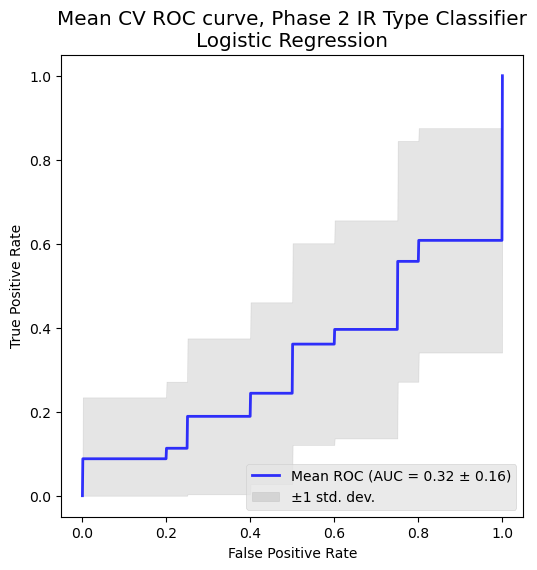

Average Train Accuracy: 99.87% ± 0.47%
Average Test Accuracy: 38.81% ± 12.97%


In [4]:
# Create a combined mask for both conditions
mask = [(r > 0) for r in rad]

# Apply the mask to your arrays
X_targets = np.log1p(X[mask])
print("X_targets shape", X_targets.shape)

y = ir_type[mask]
y = [r == 'Neutron' for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .2,
    'penalty': 'elasticnet',
    'l1_ratio': 1,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2 IR Type Classifier\nLogistic Regression"
)

In [5]:
features = pd.read_csv(targets_fname, sep='\t')
idxs = []
for idx,protein in enumerate(protein_names):
  f = features[features['Protein'] == protein]
  if len(f) > 0:
    idxs.append(idx)
print(len(idxs))
top_protein_names = protein_names[idxs]
s_idxs = np.argsort(top_protein_names)
sorted_names = top_protein_names[s_idxs]
idxs = np.array(idxs)[s_idxs]

77


X_targets shape (85, 77)
[True, False, False, True, True, False, False, True, False, False, False, True, False, True, True, False, True, True, False, False, False, True, False, True, False, True, False, False, True, True, True, True, False, True, False, False, True, False, True, False, True, False, False, True, True, False, False, True, True, False, True, False, False, False, True, False, True, True, False, False, True, False, True, True, False, True, True, False, True, False, True, True, False, False, True, False, False, True, True, False, False, False, True, True, True]
(85, 77) 85 42
Baseline Accuracy: 0.49411764705882355


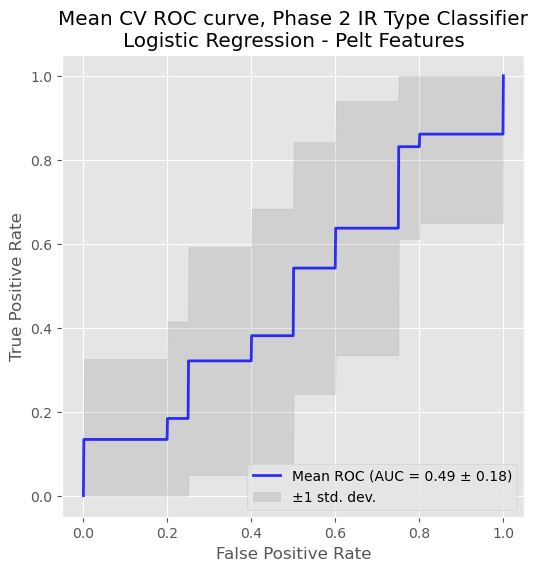

Average Train Accuracy: 97.49% ± 1.65%
Average Test Accuracy: 45.64% ± 15.86%


In [6]:
# Create a combined mask for both conditions
mask = [(r > 0) for r in rad]

# Apply the mask to your arrays
X_targets = np.log1p(X[mask][:,idxs])
print("X_targets shape", X_targets.shape)

y = ir_type[mask]
y = [r == 'Neutron' for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .5,
    'penalty': 'elasticnet',
    'l1_ratio': .5,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2 IR Type Classifier\nLogistic Regression - Pelt Features"
)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict, Union
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import warnings

def cv_with_boruta(
    labeled_X: np.ndarray, 
    y: np.ndarray, 
    protein_names: np.ndarray,
    param: Dict[str, Union[str, float, int]] = None,
    title: str = "Logistic Regression with Boruta Feature Selection",
    cv_folds: int = 5,
    cv_repeats: int = 5,
    random_state: int = 1966
) -> Tuple[List[float], List[float], np.ndarray, np.ndarray]:
    """
    Perform cross-validation with Boruta feature selection and model evaluation on separate test sets.
    
    Args:
        labeled_X: Feature matrix
        y: Target vector (binary)
        protein_names: Array of feature names
        param: Dictionary of parameters for LogisticRegression
        title: Plot title
        cv_folds: Number of folds for cross-validation
        cv_repeats: Number of repeats for cross-validation
        random_state: Random seed for reproducibility
                       
    Returns:
        Tuple of:
            - List of test set accuracies (percent)
            - Numpy array of feature selection counts
            - List of selected features by fold
            - Numpy array of summed coefficients
    """
    print("Baseline Accuracy:", np.mean(y))
    
    # Set default parameters for LogisticRegression if not provided
    default_params = {
        'C': 1.0,
        'penalty': 'elasticnet',
        'l1_ratio': 0.5,
        'solver': 'saga',
        'max_iter': 5000,
        'random_state': random_state,
        'warm_start': True,
        'tol': 1e-4,
    }
    
    # Update defaults with provided parameters
    if param is None:
        param = {}
    model_params = {**default_params, **param}
    
    # Convert inputs to numpy arrays if they aren't already
    labeled_X = np.array(labeled_X)
    y = np.array(y)
    
    # Create figure for ROC curve
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Initialize tracking variables
    all_test_preds = []
    all_test_truths = []
    all_test_probs = []
    tprs = []
    aucs = []
    test_accs = []
    mean_fpr = np.linspace(0, 1, 1000)
    feature_selection_counts = np.zeros(labeled_X.shape[1])
    selected_features_by_fold = []
    coef_sums = np.zeros(labeled_X.shape[1])
    
    # Set up cross-validation
    cv = RepeatedStratifiedKFold(
        n_splits=cv_folds, 
        n_repeats=cv_repeats, 
        random_state=random_state
    )
    
    # Counter for total iterations
    total_iterations = cv_folds * cv_repeats
    iteration = 0
    
    # Run cross-validation
    for train_idx, test_idx in cv.split(labeled_X, y):
        iteration += 1
        current_repeat = (iteration - 1) // cv_folds + 1
        current_fold = (iteration - 1) % cv_folds + 1
        
        print(f"Processing repeat {current_repeat}/{cv_repeats}, fold {current_fold}/{cv_folds} (iteration {iteration}/{total_iterations})")
        
        # Get data for this fold
        X_train = labeled_X[train_idx]
        y_train = y[train_idx]
        X_test = labeled_X[test_idx]
        y_test = y[test_idx]
        
        # Feature selection with Boruta on the training data only
        rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=random_state)
        boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=random_state, perc=95, alpha=0.1)
        
        # Scale features for Boruta
        scaler_boruta = StandardScaler()
        X_train_scaled = scaler_boruta.fit_transform(X_train)
        
        boruta.fit(X_train_scaled, y_train)
        
        # Get selected feature mask and update counts
        selected_features_mask = boruta.support_
        feature_selection_counts += selected_features_mask
        selected_features_by_fold.append((iteration, np.array(protein_names)[selected_features_mask]))
        
        print(f"  Selected {sum(selected_features_mask)} features")
        
        # Check if any features were selected
        if np.sum(selected_features_mask) == 0:
            print("  No features selected by Boruta in this fold. Skipping model evaluation.")
            continue
        
        # Use only selected features
        X_train_selected = X_train[:, selected_features_mask]
        X_test_selected = X_test[:, selected_features_mask]
        
        # Standardize the data
        ss = StandardScaler()
        X_train_scaled = ss.fit_transform(X_train_selected)
        X_test_scaled = ss.transform(X_test_selected)
        
        # Train model on fold training data
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings('ignore', category=ConvergenceWarning)
            model = LogisticRegression(**model_params)
            model.fit(X_train_scaled, y_train)
        
        # Get predictions for test data
        test_preds = model.predict(X_test_scaled)
        test_probs = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculate accuracy
        test_acc = accuracy_score(y_test, test_preds)
        test_accs.append(test_acc * 100)
        
        # Collect test predictions and true values for ROC curve
        all_test_preds.extend(test_preds)
        all_test_truths.extend(y_test)
        all_test_probs.extend(test_probs)
        
        # Calculate ROC curve metrics without plotting individual curves
        try:
            # Create a temporary RocCurveDisplay to get fpr and tpr values, but don't plot it
            from sklearn.metrics import roc_curve, roc_auc_score
            fpr, tpr, _ = roc_curve(y_test, test_probs)
            fold_auc = roc_auc_score(y_test, test_probs)
            
            # Interpolate TPR
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(fold_auc)
            
            # Track coefficients for selected features
            fold_coeffs = np.zeros(labeled_X.shape[1])
            # Map coefficients back to original feature space
            fold_coeffs[selected_features_mask] = model.coef_[0]
            coef_sums += fold_coeffs
        except Exception as e:
            print(f"  Error calculating ROC curve: {str(e)}")
    
    # Calculate and plot mean ROC curve
    if len(tprs) > 0:
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        
        ax.plot(
            mean_fpr,
            mean_tpr,
            color="b",
            label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
            lw=2,
            alpha=0.8,
        )
        
        # Add standard deviation band
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label="±1 std. dev.",
        )
        
        # Configure plot
        ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=title
        )
        ax.axis("square")
        
        # Add a diagonal reference line
        ax.plot([0, 1], [0, 1], "k--", label="No Skill (AUC = 0.5)")
        
        # Clean up legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(loc="lower right")
        
        plt.show()
    else:
        print("No valid folds to plot ROC curve.")
    
    # Calculate overall accuracy
    if len(all_test_preds) > 0:
        overall_acc = accuracy_score(all_test_truths, all_test_preds) * 100
        print(f"\nOverall Test Accuracy: {overall_acc:.2f}%")
        print(f"Average Test Accuracy: {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
    else:
        print("No predictions available to calculate accuracy.")
    
    # Print feature selection statistics
    total_iterations = cv_folds * cv_repeats
    print("\n=== Feature Selection Statistics ===")
    print(f"Total number of features: {labeled_X.shape[1]}")
    print(f"Number of proteins never selected: {sum(feature_selection_counts == 0)}")
    print(f"Number of proteins selected in all iterations: {sum(feature_selection_counts == total_iterations)}")
    
    # Display feature selection frequencies
    feature_selection_df = pd.DataFrame({
        'Protein': protein_names,
        'Selection_Count': feature_selection_counts,
        'Selection_Frequency': feature_selection_counts / total_iterations * 100,
        'Coefficient_Sum': coef_sums
    })
    
    # Sort by selection frequency in descending order
    feature_selection_df = feature_selection_df.sort_values('Selection_Count', ascending=False)
    
    # Print proteins with non-zero selection frequency
    print("\n=== Features Selected by Boruta (with selection counts) ===")
    for idx, row in feature_selection_df[feature_selection_df['Selection_Count'] > 0].iterrows():
        print(f"{row['Protein']}: {int(row['Selection_Count'])}/{total_iterations} iterations ({row['Selection_Frequency']:.1f}%) - Coef: {row['Coefficient_Sum']:.4f}")
    
    # Print summary of features selected by iteration
    print(f"\n=== Summary of Features Selected by Iteration ===")
    for iteration, selected_features in selected_features_by_fold:
        print(f"Iteration {iteration}: {len(selected_features)} features selected")
    
    return test_accs, feature_selection_counts, selected_features_by_fold, coef_sums

X_targets shape (85, 5360)
[True, False, False, True, True, False, False, True, False, False, False, True, False, True, True, False, True, True, False, False, False, True, False, True, False, True, False, False, True, True, True, True, False, True, False, False, True, False, True, False, True, False, False, True, True, False, False, True, True, False, True, False, False, False, True, False, True, True, False, False, True, False, True, True, False, True, True, False, True, False, True, True, False, False, True, False, False, True, True, False, False, False, True, True, True]
(85, 5360) 85 42
Baseline Accuracy: 0.49411764705882355
Processing repeat 1/5, fold 1/5 (iteration 1/25)
  Selected 25 features
Processing repeat 1/5, fold 2/5 (iteration 2/25)
  Selected 28 features
Processing repeat 1/5, fold 3/5 (iteration 3/25)
  Selected 23 features
Processing repeat 1/5, fold 4/5 (iteration 4/25)
  Selected 25 features
Processing repeat 1/5, fold 5/5 (iteration 5/25)
  Selected 29 features
Pro

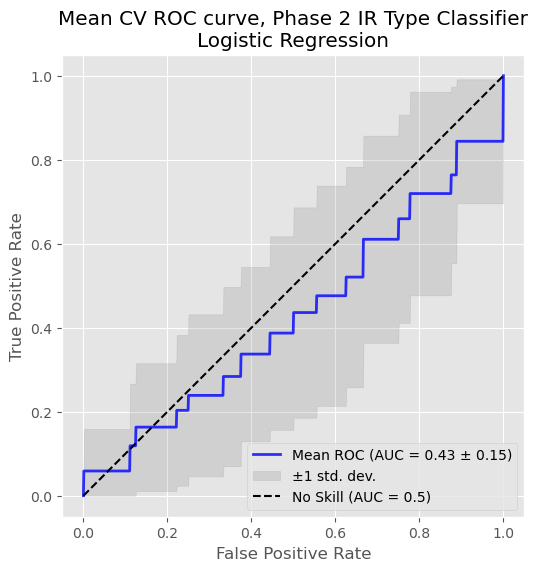


Overall Test Accuracy: 43.76%
Average Test Accuracy: 43.76% ± 12.79%

=== Feature Selection Statistics ===
Total number of features: 5360
Number of proteins never selected: 5121
Number of proteins selected in all iterations: 1

=== Features Selected by Boruta (with selection counts) ===
sp|E9Q634|MYO1E_MOUSE: 25/25 iterations (100.0%) - Coef: -19.5389
sp|Q5EBH1|RASF5_MOUSE: 24/25 iterations (96.0%) - Coef: 9.9928
sp|Q02614|S30BP_MOUSE: 23/25 iterations (92.0%) - Coef: 14.3431
sp|O35250|EXOC7_MOUSE: 17/25 iterations (68.0%) - Coef: 4.9341
sp|Q99L85|ELP5_MOUSE: 14/25 iterations (56.0%) - Coef: 7.2722
sp|G3X8U3|QNG1_MOUSE: 14/25 iterations (56.0%) - Coef: -4.6777
sp|Q9R059|FHL3_MOUSE: 12/25 iterations (48.0%) - Coef: 6.5258
sp|P15535|B4GT1_MOUSE: 12/25 iterations (48.0%) - Coef: -3.5689
sp|Q8CD92|TTC27_MOUSE: 11/25 iterations (44.0%) - Coef: 7.1194
sp|Q8BMI3|GGA3_MOUSE: 11/25 iterations (44.0%) - Coef: 2.9551
sp|P17809|GTR1_MOUSE: 10/25 iterations (40.0%) - Coef: 2.2940
sp|P97370|AT1B3_M

In [8]:
# Create a combined mask for both conditions
mask = [(r > 0) for r in rad]

# Apply the mask to your arrays
X_targets = np.log1p(X[mask])
print("X_targets shape", X_targets.shape)

y = ir_type[mask]
y = [r == 'Neutron' for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': 1,
    'penalty': 'elasticnet',
    'l1_ratio': 0.5,
    'max_iter': 100000
}

inner_accs, feature_selection_counts, selected_features_by_fold, coef_sums = cv_with_boruta(
    X_targets, 
    y, 
    protein_names,
    param, 
    title="Mean CV ROC curve, Phase 2 IR Type Classifier\nLogistic Regression"
)